In [2]:
import torch
import torchvision.models as models
import cv2
import numpy as np
import os
from keras.preprocessing import image
import skimage.feature as sf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Convolution3D, MaxPooling3D
import keras.optimizers as opt
from keras.utils import np_utils, generic_utils
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import train_test_split

import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD

from sklearn import preprocessing
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [3]:
def load_data(num_vids, num_frames, skipframes):
  
  parent_dir = '/content/drive/Shared drives/Projects/Fall 2020 Projects/DL/kth'
  parent_dir = os.path.abspath(parent_dir)
  
  frames_list = []
  Xtr=[]
  labels=[]
  vid_count = 0
  frame_count = 0
  
  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']#jogging out

  for act_class in act_classes:
    vid_count = 0
    class_dir = os.path.join(parent_dir, act_class)
    vid_list = []
    for vid_file in os.listdir(class_dir):
      vid_count += 1
      if (vid_count<=num_vids):
        frames_list = []
        print ("IN: ",vid_file, vid_count)
        file = os.path.join(class_dir,vid_file)
        vid_cap = cv2.VideoCapture(file)
        success , frame = vid_cap.read()
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_count = 1

        #remove empty frames
        while success and frame_count<=num_frames:
          blurred_image = cv2.GaussianBlur(frame, (7,7), 0)  
          canny2 = cv2.Canny(blurred_image, 50, 150)          #edge detection

          while np.mean(canny2) == 0:
            success , frame = vid_cap.read()
            blurred_image = cv2.GaussianBlur(frame, (7,7), 0)  
            canny2 = cv2.Canny(blurred_image, 50, 150)   

          if (np.mean(canny2) != 0 and frame_count <= num_frames): # no edge means no character in frame
            color_frame= cv2.cvtColor(gray_frame,cv2.COLOR_GRAY2RGB)
            norm = cv2.normalize(color_frame, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            resized = cv2.resize(norm, (64,64), interpolation = cv2.INTER_AREA)
            resized=np.array(resized)
            x=resized.reshape((1,3,64,64))
            frames_list.append(x)
            frame_count += 1
          
          for skip in range (0, skipframes):
            success , frame = vid_cap.read()
          while not success:
            success , frame = vid_cap.read()
          if success and frame_count <= num_frames:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if frame_count!=(num_frames+1):
          print( vid_file, frame_count)

        Xtr.append(frames_list)
        labels.append(act_class)
  return Xtr,labels

In [4]:
def feature_extractor():
  model = models.mobilenet_v2(pretrained=True)
  new_base =  (list(model.children())[:-1])[0]
  return new_base

def extract_features(Xtr,new_base):
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)
      output= new_base[:3](x)
      j=output
  return Xtr

In [6]:
def preprocess(labels,Xtr, nb_classes):

  y=np.zeros(len(labels))
  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']
  for i in range (0, len(y)):
    if labels[i] in act_classes:
      y[i]=act_classes.index(labels[i])
  
  # convert class vectors to binary class matrices
  Y_train = np_utils.to_categorical(y, nb_classes)
  
  Xtr_new=np.array(len(Xtr))
  Xtr_new=np.array(Xtr)
  print("Current shape:", Xtr_new.shape)
  Xtr_new=Xtr_new.reshape(598,3,25,64,64)
  print("New shape:", Xtr_new.shape)
  return Xtr_new,Y_train

In [5]:
# Define model
def kerasmod3():

  model = Sequential()
  model.add(BatchNormalization())

  model.add(Convolution3D(8, 5, input_shape=(3,15,64,64), activation='relu', data_format = 'channels_first'))
  model.add(Convolution3D(16, 3, activation='relu'))
  model.add(Convolution3D(32, 3, activation='relu'))

  model.add(Dropout(0.1))
  model.add(MaxPooling3D(pool_size=2))
  

  model.add(Dropout(0.1))

  model.add(Flatten())
  
  model.add(Dropout(0.1))

  model.add(Dense(128, kernel_initializer='normal', activation='relu'))

  model.add(Dense(6, kernel_initializer='normal'))

  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

  return model

In [20]:
def main():

  act_classes=['boxing','handwaving','handclapping','jogging','running','walking']
  num_vids=100
  num_frames=25
  skipframes=2
  nb_classes =6
  #loading and preprocessing
  X,labels=load_data(num_vids, num_frames, skipframes)

  new_base=feature_extractor()
  Xtr=extract_features(X,new_base)

  Xtr_new, Y_train=preprocess(labels,Xtr,nb_classes)  
  
  # CNN Training parameters

  X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,Y_train, 
                                                                    test_size=0.2, random_state=21)

  # Train the model
  model=kerasmod3()

  hist = model.fit(X_train_new, y_train_new, batch_size=  32, epochs = 20,shuffle=True)
  #hist = model.fit(X_train_new, y_train_new, batch_size=32,epochs=20,validation_split=0.2, shuffle=True)


  # Evaluate the model
  score = model.evaluate(X_val_new, y_val_new, batch_size=32)
  print('Test score:', score[0])
  print('Test accuracy:', score[1]) 
  model.save("kth_model.h5")
  y_val_new1 = [np.argmax(y, axis=None, out=None) for y in y_val_new]
  y_pred=model.predict_classes(X_val_new)
  
  con_mat = tf.math.confusion_matrix(labels=y_val_new1, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
  print(con_mat_df)
  print(classification_report(y_val_new1,y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

IN:  person01_boxing_d1_uncomp.avi 1
IN:  person01_boxing_d3_uncomp.avi 2
IN:  person01_boxing_d4_uncomp.avi 3
IN:  person02_boxing_d1_uncomp.avi 4
IN:  person01_boxing_d2_uncomp.avi 5
IN:  person02_boxing_d2_uncomp.avi 6
IN:  person02_boxing_d3_uncomp.avi 7
IN:  person03_boxing_d2_uncomp.avi 8
IN:  person07_boxing_d2_uncomp.avi 9
IN:  person06_boxing_d1_uncomp.avi 10
IN:  person05_boxing_d2_uncomp.avi 11
IN:  person04_boxing_d3_uncomp.avi 12
IN:  person06_boxing_d4_uncomp.avi 13
IN:  person04_boxing_d1_uncomp.avi 14
IN:  person05_boxing_d4_uncomp.avi 15
IN:  person04_boxing_d2_uncomp.avi 16
IN:  person06_boxing_d2_uncomp.avi 17
IN:  person03_boxing_d3_uncomp.avi 18
IN:  person04_boxing_d4_uncomp.avi 19
IN:  person05_boxing_d3_uncomp.avi 20
IN:  person07_boxing_d1_uncomp.avi 21
IN:  person06_boxing_d3_uncomp.avi 22
IN:  person07_boxing_d4_uncomp.avi 23
IN:  person07_boxing_d3_uncomp.avi 24
IN:  person03_boxing_d1_uncomp.avi 25
IN:  person03_boxing_d4_uncomp.avi 26
IN:  person02_boxing_

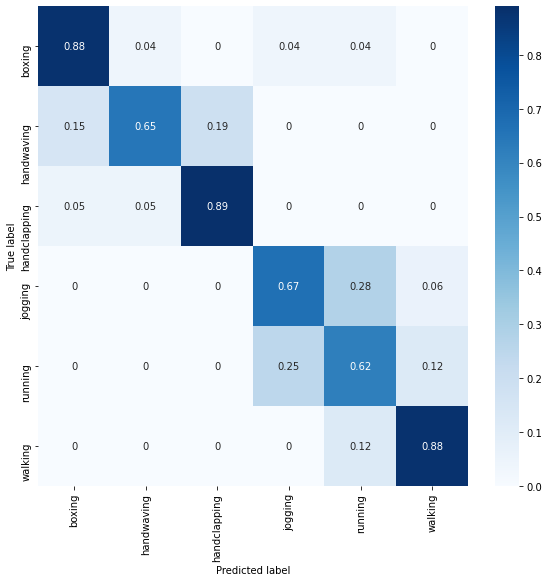

In [23]:
if __name__ == "__main__":
    main()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
def getListOfDir(path):
    dirs  = os.listdir(path)
    sportsActionsCount = 0
    filtered_dir  = []
    for dir in dirs:
        if not dir.startswith("."):
            filtered_dir.append(dir)
    return filtered_dir

  def getImageList(imageDirectory):
    rImages = glob.glob(imageDirectory + "/*.jpg")
    rImages +=  glob.glob(imageDirectory + "/*.jpeg")
    rImages +=  glob.glob(imageDirectory + "/*.png")
    return rImages
  
  sportsActionPath = "/content/drive/Shareddrives/Projects/Fall 2020 Projects/DL/UCF_Sports"
  labels = getListOfDir(sportsActionPath)
  videoLabels = []
  videoFrames = []
  print("INFO: Sports Action - ", labels)
  for label in labels:
      for video in videoList:
        videoLabels.append(label)
        videoPath = sportsActionDir + "/" + video
        print("\tVideo Path:", videoPath)
        frames = getImageList(videoPath)
        f  = []
        for iFrame in frames:
          frame = cv2.imread(iFrame)
          f.append(frame)
        videoFrames.append(f)
  print(videoLabels)
  print(len(videoFrames))